## 1. Preliminary

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import yaml
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import warnings
warnings.filterwarnings("ignore")
from utils import load_paper_node, load_paper_edge

## 2. Load and inspect the dataset

In [3]:
# Load config file and get the path of csv files
with open("./config/config.yaml", "r") as file:
    config = yaml.safe_load(file)
PAPER_NODE = Path(config["data"]["paper"]["node"])
PAPER_EDGE = Path(config["data"]["paper"]["edge"])

In [ ]:
df_node = load_paper_node(PAPER_NODE, False)    # The NAs in df will not be filled with empty string

2024-12-11 10:41:34 - SocialNetwork - INFO - Load data\paper\node.csv as dataframe, memory usage 1575.59 MB
2024-12-11 10:41:34 - SocialNetwork - INFO - Function 'load_paper_node' executed in 17.76 second(s)


In [5]:
df_node.head()

,id,title,authors,year,venue,out_d,in_d
0,555036b37cea80f954149ffc,Approximate Distance Oracles with Improved Que...,[287837],2015,Encyclopedia of Algorithms,0,0
1,555036b37cea80f954149ffd,Subset Sum Algorithm for Bin Packing.,[855925],2015,Encyclopedia of Algorithms,0,0
2,555036b37cea80f954149ffe,Minimum Weighted Completion Time.,"[1714844, 1038326, 1578020, 140095]",2015,Encyclopedia of Algorithms,0,0
3,555036b37cea80f954149fff,Multiple String Matching.,"[1124727, 1658178]",2015,Encyclopedia of Algorithms,0,0
4,555036b37cea80f95414a000,Fault-Tolerant Connected Dominating Set.,"[407556, 1756780, 1760018, 47850]",2015,Encyclopedia of Algorithms,0,0


## 3. Count NaN values

In [6]:
df_node.loc[df_node['year'] == 0, 'year'] = np.nan
nan_counts = df_node.isna().sum()
print(nan_counts)

id             0
title          0
authors    52010
year           7
venue      56785
out_d          0
in_d           0
dtype: int64


## 4. Plot the distribution of list columns

In [14]:
# Calculate the number of authors and references for each row
df_node["num_authors"] = df_node["authors"].apply(len)

# Calculate basic statistics
print(df_node["num_authors"].describe())
print("=" * 20)
print(df_node["out_d"].describe())
print("=" * 20)
print(df_node["in_d"].describe())

count    3.680007e+06
mean     2.836479e+00
std      1.748325e+00
min      0.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      4.000000e+00
max      1.390000e+02
Name: num_authors, dtype: float64
count    3.680007e+06
mean     5.097998e-01
std      1.294739e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      6.090000e+02
Name: out_d, dtype: float64
count    3.680007e+06
mean     5.097998e-01
std      1.059119e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.067000e+03
Name: in_d, dtype: float64


count    3.626640e+06
mean     2.867512e+00
std      1.640951e+00
min      1.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      4.000000e+00
max      2.000000e+01
Name: num_authors, dtype: float64


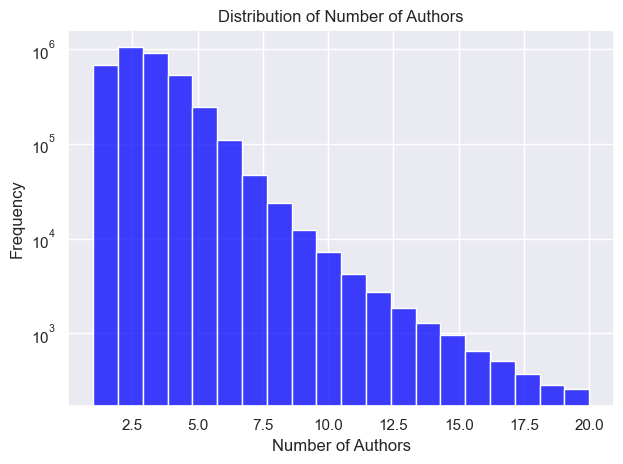

In [23]:
df_filtered_authors = df_node[(df_node['num_authors'] > 0) & (df_node['num_authors'] <= 20)]
print(df_filtered_authors["num_authors"].describe())

# Plot the distribution of the number of authors
sns.histplot(df_filtered_authors['num_authors'], color='blue', bins=20)
plt.title('Distribution of Number of Authors')
plt.xlabel('Number of Authors')
plt.ylabel('Frequency')
plt.yscale("log")
plt.tight_layout()
plt.show()

count    1.773552e+06
mean     1.050111e+00
std      1.073527e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      9.900000e+01
Name: out_d, dtype: float64


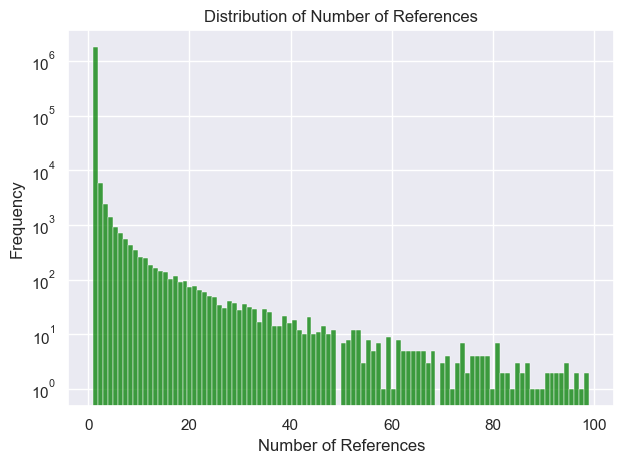

In [9]:
df_filtered_out_d = df_node[(df_node['out_d'] > 0) & (df_node['out_d'] <= 100)]
print(df_filtered_out_d["out_d"].describe())

# Plot the distribution of the number of references
sns.histplot(df_filtered_out_d['out_d'], color='green', bins=100)
plt.title('Distribution of Number of References')
plt.xlabel('Number of References')
plt.ylabel('Frequency')
plt.yscale("log")
plt.tight_layout()
plt.show()

count    35162.000000
mean        29.818099
std         22.514989
min          1.000000
25%         13.000000
50%         23.000000
75%         41.000000
max        100.000000
Name: in_d, dtype: float64


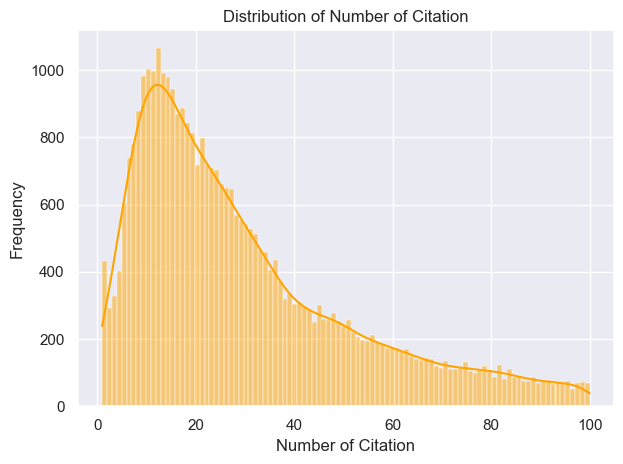

In [10]:
df_filtered_in_d = df_node[(df_node['in_d'] > 0) & (df_node['in_d'] <= 100)]
print(df_filtered_in_d["in_d"].describe())

# Plot the distribution of the number of references
sns.histplot(df_filtered_in_d['in_d'], color='orange', kde=True, bins=100)
plt.title('Distribution of Number of Citation')
plt.xlabel('Number of Citation')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## 5. Probe other columns

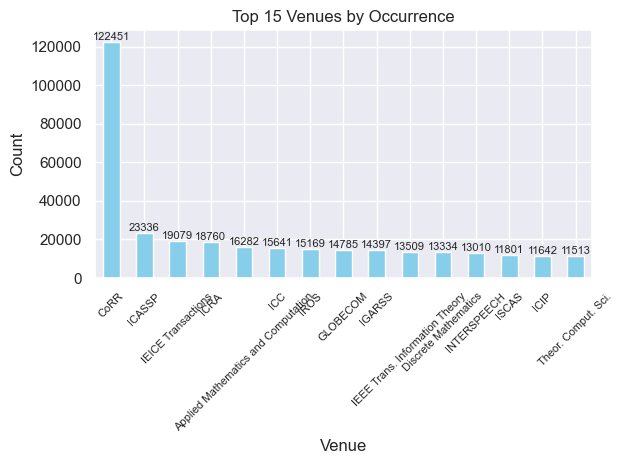

In [11]:
# Get the unique venues and their occurrences
venue_counts = df_node['venue'].value_counts()

# Get the first 15 items
top_15_venues = venue_counts.head(15)

# Plot the first 15 venues
top_15_venues.plot(kind='bar', color='skyblue')
plt.title('Top 15 Venues by Occurrence')
plt.xlabel('Venue')
plt.ylabel('Count')
plt.xticks(rotation=45, fontsize=8)
plt.xticks(rotation=45, fontsize=8)
for i, count in enumerate(top_15_venues):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.show()

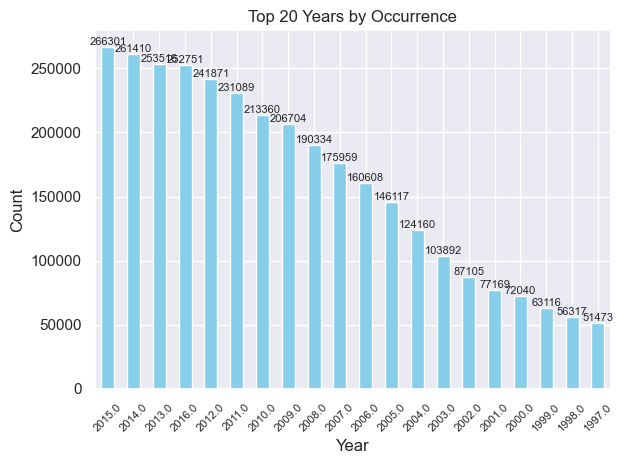

In [12]:
# Get the unique venues and their occurrences
year_counts = df_node['year'].value_counts()

top_20_years = year_counts.head(20)

# Plot the first 20 years
top_20_years.plot(kind='bar', color='skyblue')
plt.title('Top 20 Years by Occurrence')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45, fontsize=8)
for i, count in enumerate(top_20_years):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.show()

## 6. Visualize the edges

2024-12-11 10:45:49 - SocialNetwork - INFO - Load data\paper\edge.csv as dataframe, memory usage 289.84 MB
2024-12-11 10:45:49 - SocialNetwork - INFO - Function 'load_paper_edge' executed in 1.65 second(s)


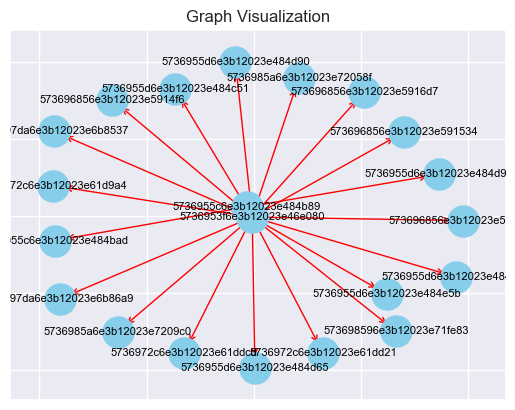

In [26]:
df_edge = load_paper_edge(PAPER_EDGE)
# Create a graph using NetworkX
G = nx.from_pandas_edgelist(df_edge, source='src', target='dst', create_using=nx.DiGraph())

# Get a subset of edges
subgraph_edges = list(G.edges())[:20] 
subgraph = G.edge_subgraph(subgraph_edges)
pos = nx.spring_layout(subgraph)

# Plot the graph
nx.draw_networkx_nodes(subgraph, pos, node_size=500, node_color="skyblue")
nx.draw_networkx_edges(subgraph, pos, edge_color="red", arrows=True, arrowsize=10, arrowstyle='->')
nx.draw_networkx_labels(subgraph, pos, font_size=8, font_color="black")
plt.title("Graph Visualization")
plt.show()